In [1]:
! pip install pytorch-metric-learning
! pip install MulticoreTSNE

In [2]:
import timm
import torch
from torch import optim
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from cycler import cycler
from torch import optim
import os

import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
from pytorch_metric_learning.miners import TripletMarginMiner
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.losses import TripletMarginLoss
from pytorch_metric_learning.reducers import ThresholdReducer

import glob
import cv2
from PIL import Image

In [3]:
class CFG:
    data_path = "./dataset/"
    exp = "ex2"
    model_name = ["vgg16","efficientnet_b0","resnet34d"]
    epoch = 20
    pretrained = True
    inp_channels = 1
    batch_size = 64
    lr = 1e-5
    out_features = 128
    seed = 42
    device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=CFG.seed)


OUTPUT_DIR = './'+CFG.exp+'/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [5]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = datasets.FashionMNIST(CFG.data_path, train=True, download=False, transform=transform)
test_dataset = datasets.FashionMNIST(CFG.data_path, train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False)

In [6]:
class CustomModel(nn.Module):
    def __init__(
        self, model_name=CFG.model_name, n_class=CFG.out_features, pretrained=CFG.pretrained, in_chans=CFG.inp_channels):
        super().__init__()
        self.backbone = timm.create_model(
            model_name, pretrained=pretrained, num_classes = n_class, in_chans=in_chans)
      
    def forward(self, x):
        x = self.backbone(x)
        output = x
        return output

In [7]:
def train(model, loss_func, mining_func, device, dataloader, optimizer, epoch):
    model.train() 
    for idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(inputs)
#         indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels)
        loss.backward()
        optimizer.step()
        if idx % 100 == 0:
            print('Epoch {} Iteration {}: Loss = {}'.format(epoch, idx, loss))

In [8]:
def test(model, dataloader, device, epoch):
    _predicted_metrics = []
    _true_labels = []
    with torch.no_grad():    
        for i, (inputs,  labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            metric = model(inputs).detach().cpu().numpy()
            metric = metric.reshape(metric.shape[0], metric.shape[1])
            _predicted_metrics.append(metric)
            _true_labels.append(labels.detach().cpu().numpy())
    return np.concatenate(_predicted_metrics), np.concatenate(_true_labels)

In [9]:
def tsne(epoch):
    inf_model = CustomModel(model_name=CFG.model_name[2]).to(CFG.device)
    inf_model.load_state_dict(torch.load(OUTPUT_DIR + "/" + f'epoch{epoch}_model.pth'))
    test_predicted_metrics, test_true_labels = test(inf_model, test_loader, CFG.device, epoch)
    tSNE_metrics = TSNE(n_components=2, random_state=0,n_jobs=4).fit_transform(test_predicted_metrics)

    plt.scatter(tSNE_metrics[:, 0], tSNE_metrics[:, 1], c=test_true_labels)
    plt.colorbar()
    plt.savefig(OUTPUT_DIR + "/" + f"output_epoch{epoch}.jpg")
    plt.xlim([-40,40])
    plt.ylim([-40,40])
    plt.show()

In [10]:
def create_gif():
    pictures=[]
    for i in range(1,CFG.epoch+1):
        pic_name=OUTPUT_DIR + f"output_epoch{i}.jpg"
        img = Image.open(pic_name)
        pictures.append(img)
    
    pictures[0].save(OUTPUT_DIR + "/" + 'anime.gif',save_all=True, append_images=pictures[1:],
    optimize=False, duration=500, loop=0)

In [11]:
from pytorch_metric_learning import losses, testers

Epoch 1/20
----------
Epoch 1 Iteration 0: Loss = 37.37355041503906
Epoch 1 Iteration 100: Loss = 37.57468032836914
Epoch 1 Iteration 200: Loss = 36.57392120361328
Epoch 1 Iteration 300: Loss = 36.236297607421875
Epoch 1 Iteration 400: Loss = 36.516883850097656
Epoch 1 Iteration 500: Loss = 32.832191467285156
Epoch 1 Iteration 600: Loss = 34.358116149902344
Epoch 1 Iteration 700: Loss = 33.035057067871094
Epoch 1 Iteration 800: Loss = 32.15250015258789
Epoch 1 Iteration 900: Loss = 31.361595153808594


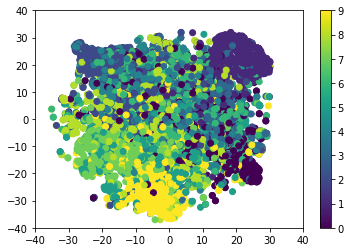

Epoch 2/20
----------
Epoch 2 Iteration 0: Loss = 30.812942504882812
Epoch 2 Iteration 100: Loss = 30.035018920898438
Epoch 2 Iteration 200: Loss = 27.916934967041016
Epoch 2 Iteration 300: Loss = 28.114761352539062
Epoch 2 Iteration 400: Loss = 26.840328216552734
Epoch 2 Iteration 500: Loss = 22.782596588134766
Epoch 2 Iteration 600: Loss = 22.507600784301758
Epoch 2 Iteration 700: Loss = 21.40265655517578
Epoch 2 Iteration 800: Loss = 19.456092834472656
Epoch 2 Iteration 900: Loss = 14.156620025634766


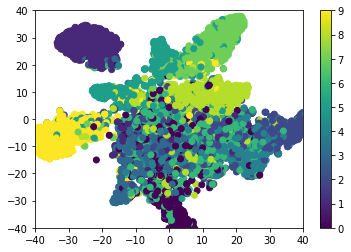

Epoch 3/20
----------
Epoch 3 Iteration 0: Loss = 18.468658447265625
Epoch 3 Iteration 100: Loss = 18.59503746032715
Epoch 3 Iteration 200: Loss = 17.25918960571289
Epoch 3 Iteration 300: Loss = 19.867733001708984
Epoch 3 Iteration 400: Loss = 18.03040313720703
Epoch 3 Iteration 500: Loss = 20.098506927490234
Epoch 3 Iteration 600: Loss = 12.3489408493042
Epoch 3 Iteration 700: Loss = 17.290584564208984
Epoch 3 Iteration 800: Loss = 16.7434139251709
Epoch 3 Iteration 900: Loss = 16.31037139892578


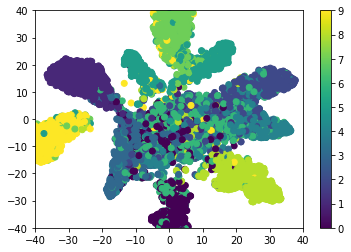

Epoch 4/20
----------
Epoch 4 Iteration 0: Loss = 15.195697784423828
Epoch 4 Iteration 100: Loss = 12.713866233825684
Epoch 4 Iteration 200: Loss = 11.350475311279297
Epoch 4 Iteration 300: Loss = 16.66993522644043
Epoch 4 Iteration 400: Loss = 15.143776893615723
Epoch 4 Iteration 500: Loss = 11.200989723205566
Epoch 4 Iteration 600: Loss = 13.896743774414062
Epoch 4 Iteration 700: Loss = 14.405065536499023
Epoch 4 Iteration 800: Loss = 13.254232406616211
Epoch 4 Iteration 900: Loss = 9.251482009887695


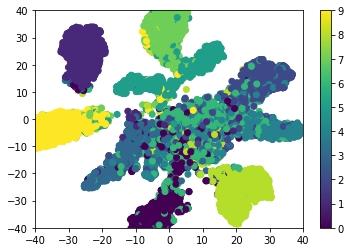

Epoch 5/20
----------
Epoch 5 Iteration 0: Loss = 9.319482803344727
Epoch 5 Iteration 100: Loss = 11.990363121032715
Epoch 5 Iteration 200: Loss = 9.86002254486084
Epoch 5 Iteration 300: Loss = 11.635916709899902
Epoch 5 Iteration 400: Loss = 10.143550872802734
Epoch 5 Iteration 500: Loss = 12.756509780883789
Epoch 5 Iteration 600: Loss = 12.849488258361816
Epoch 5 Iteration 700: Loss = 5.909477710723877
Epoch 5 Iteration 800: Loss = 12.420832633972168
Epoch 5 Iteration 900: Loss = 13.413561820983887


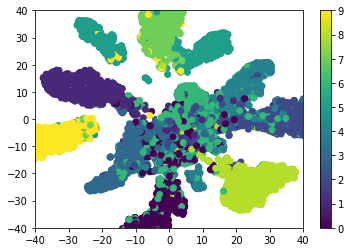

Epoch 6/20
----------
Epoch 6 Iteration 0: Loss = 8.088327407836914
Epoch 6 Iteration 100: Loss = 11.85873031616211
Epoch 6 Iteration 200: Loss = 9.13958740234375
Epoch 6 Iteration 300: Loss = 6.8343915939331055
Epoch 6 Iteration 400: Loss = 9.937156677246094
Epoch 6 Iteration 500: Loss = 13.308558464050293
Epoch 6 Iteration 600: Loss = 11.693231582641602
Epoch 6 Iteration 700: Loss = 9.620152473449707
Epoch 6 Iteration 800: Loss = 12.743117332458496
Epoch 6 Iteration 900: Loss = 8.52084732055664


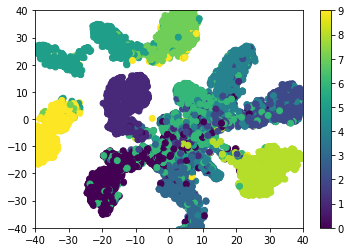

Epoch 7/20
----------
Epoch 7 Iteration 0: Loss = 9.384445190429688
Epoch 7 Iteration 100: Loss = 10.265405654907227
Epoch 7 Iteration 200: Loss = 12.755203247070312
Epoch 7 Iteration 300: Loss = 7.503871917724609
Epoch 7 Iteration 400: Loss = 7.481840133666992
Epoch 7 Iteration 500: Loss = 8.078392028808594
Epoch 7 Iteration 600: Loss = 7.326913833618164
Epoch 7 Iteration 700: Loss = 4.545444488525391
Epoch 7 Iteration 800: Loss = 13.117856979370117
Epoch 7 Iteration 900: Loss = 8.176383972167969


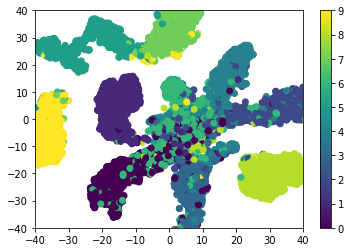

Epoch 8/20
----------
Epoch 8 Iteration 0: Loss = 6.957130432128906
Epoch 8 Iteration 100: Loss = 7.945631504058838
Epoch 8 Iteration 200: Loss = 10.321914672851562
Epoch 8 Iteration 300: Loss = 6.991801738739014
Epoch 8 Iteration 400: Loss = 9.819430351257324
Epoch 8 Iteration 500: Loss = 9.788412094116211
Epoch 8 Iteration 600: Loss = 7.164073944091797
Epoch 8 Iteration 700: Loss = 10.879531860351562
Epoch 8 Iteration 800: Loss = 7.7328081130981445
Epoch 8 Iteration 900: Loss = 4.181922435760498


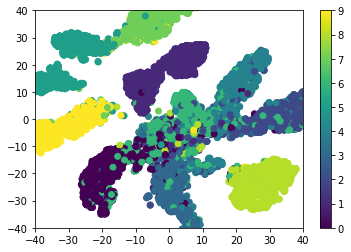

Epoch 9/20
----------
Epoch 9 Iteration 0: Loss = 6.716792583465576
Epoch 9 Iteration 100: Loss = 7.3078107833862305
Epoch 9 Iteration 200: Loss = 5.636706352233887
Epoch 9 Iteration 300: Loss = 10.714775085449219
Epoch 9 Iteration 400: Loss = 10.354593276977539
Epoch 9 Iteration 500: Loss = 10.321725845336914
Epoch 9 Iteration 600: Loss = 5.762208938598633
Epoch 9 Iteration 700: Loss = 4.244717597961426
Epoch 9 Iteration 800: Loss = 5.01076078414917
Epoch 9 Iteration 900: Loss = 5.455965518951416


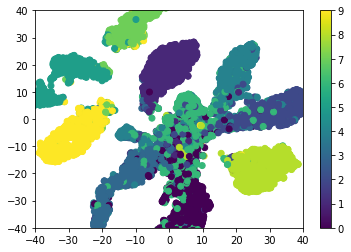

Epoch 10/20
----------
Epoch 10 Iteration 0: Loss = 10.90266227722168
Epoch 10 Iteration 100: Loss = 6.42576789855957
Epoch 10 Iteration 200: Loss = 6.223237991333008
Epoch 10 Iteration 300: Loss = 5.825925350189209
Epoch 10 Iteration 400: Loss = 8.482988357543945
Epoch 10 Iteration 500: Loss = 10.516824722290039
Epoch 10 Iteration 600: Loss = 7.011104106903076
Epoch 10 Iteration 700: Loss = 8.075763702392578
Epoch 10 Iteration 800: Loss = 9.001237869262695
Epoch 10 Iteration 900: Loss = 8.125077247619629


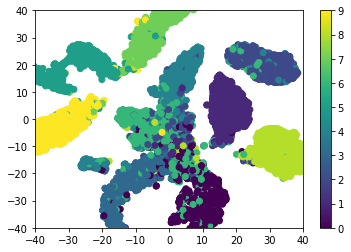

Epoch 11/20
----------
Epoch 11 Iteration 0: Loss = 4.553781032562256
Epoch 11 Iteration 100: Loss = 4.1631059646606445
Epoch 11 Iteration 200: Loss = 5.658670425415039
Epoch 11 Iteration 300: Loss = 7.291812896728516
Epoch 11 Iteration 400: Loss = 4.7038774490356445
Epoch 11 Iteration 500: Loss = 3.766432285308838
Epoch 11 Iteration 600: Loss = 3.6697187423706055
Epoch 11 Iteration 700: Loss = 5.09453010559082
Epoch 11 Iteration 800: Loss = 3.3847522735595703
Epoch 11 Iteration 900: Loss = 6.416778087615967


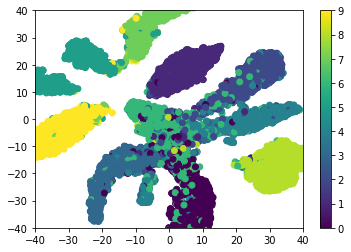

Epoch 12/20
----------
Epoch 12 Iteration 0: Loss = 3.515244483947754
Epoch 12 Iteration 100: Loss = 7.413333892822266
Epoch 12 Iteration 200: Loss = 8.247018814086914
Epoch 12 Iteration 300: Loss = 6.7675251960754395
Epoch 12 Iteration 400: Loss = 6.331114768981934
Epoch 12 Iteration 500: Loss = 7.050322532653809
Epoch 12 Iteration 600: Loss = 6.494344234466553
Epoch 12 Iteration 700: Loss = 5.902045249938965
Epoch 12 Iteration 800: Loss = 8.009159088134766
Epoch 12 Iteration 900: Loss = 6.753173351287842


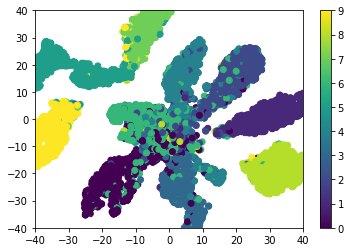

Epoch 13/20
----------
Epoch 13 Iteration 0: Loss = 4.57565450668335
Epoch 13 Iteration 100: Loss = 5.613311767578125
Epoch 13 Iteration 200: Loss = 4.26468563079834
Epoch 13 Iteration 300: Loss = 7.174393177032471
Epoch 13 Iteration 400: Loss = 7.981390953063965
Epoch 13 Iteration 500: Loss = 8.298578262329102
Epoch 13 Iteration 600: Loss = 6.225329875946045
Epoch 13 Iteration 700: Loss = 4.724182605743408
Epoch 13 Iteration 800: Loss = 7.3385467529296875
Epoch 13 Iteration 900: Loss = 4.980770587921143


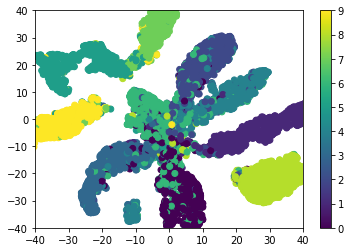

Epoch 14/20
----------
Epoch 14 Iteration 0: Loss = 7.583045959472656
Epoch 14 Iteration 100: Loss = 6.615616798400879
Epoch 14 Iteration 200: Loss = 4.8686370849609375
Epoch 14 Iteration 300: Loss = 7.385933876037598
Epoch 14 Iteration 400: Loss = 1.2355176210403442
Epoch 14 Iteration 500: Loss = 4.568236351013184
Epoch 14 Iteration 600: Loss = 5.722830772399902
Epoch 14 Iteration 700: Loss = 4.879868030548096
Epoch 14 Iteration 800: Loss = 4.412850856781006
Epoch 14 Iteration 900: Loss = 7.223839282989502


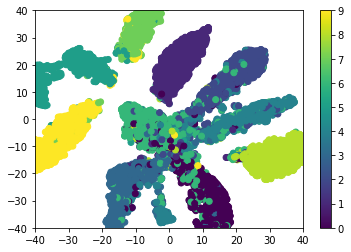

Epoch 15/20
----------
Epoch 15 Iteration 0: Loss = 3.5211398601531982
Epoch 15 Iteration 100: Loss = 4.564920425415039
Epoch 15 Iteration 200: Loss = 7.257470607757568
Epoch 15 Iteration 300: Loss = 6.607930660247803
Epoch 15 Iteration 400: Loss = 6.565359592437744
Epoch 15 Iteration 500: Loss = 1.8927534818649292
Epoch 15 Iteration 600: Loss = 5.190282821655273
Epoch 15 Iteration 700: Loss = 4.418305397033691
Epoch 15 Iteration 800: Loss = 2.8787083625793457
Epoch 15 Iteration 900: Loss = 5.497824668884277


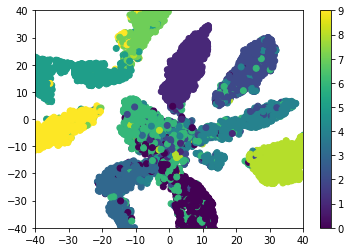

Epoch 16/20
----------
Epoch 16 Iteration 0: Loss = 3.16371488571167
Epoch 16 Iteration 100: Loss = 3.294055461883545
Epoch 16 Iteration 200: Loss = 6.069162845611572
Epoch 16 Iteration 300: Loss = 4.547424793243408
Epoch 16 Iteration 400: Loss = 7.788902282714844
Epoch 16 Iteration 500: Loss = 10.363643646240234
Epoch 16 Iteration 600: Loss = 6.123140335083008
Epoch 16 Iteration 700: Loss = 3.562981128692627
Epoch 16 Iteration 800: Loss = 4.696450710296631
Epoch 16 Iteration 900: Loss = 3.951690435409546


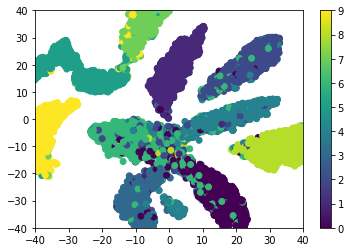

Epoch 17/20
----------
Epoch 17 Iteration 0: Loss = 2.618157386779785
Epoch 17 Iteration 100: Loss = 4.578636169433594
Epoch 17 Iteration 200: Loss = 1.8845183849334717
Epoch 17 Iteration 300: Loss = 3.660374879837036
Epoch 17 Iteration 400: Loss = 6.405418395996094
Epoch 17 Iteration 500: Loss = 2.1057522296905518
Epoch 17 Iteration 600: Loss = 1.9439685344696045
Epoch 17 Iteration 700: Loss = 3.3785085678100586
Epoch 17 Iteration 800: Loss = 4.012718200683594
Epoch 17 Iteration 900: Loss = 1.9596526622772217


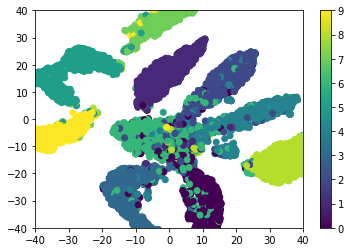

Epoch 18/20
----------
Epoch 18 Iteration 0: Loss = 1.1162177324295044
Epoch 18 Iteration 100: Loss = 3.69103741645813
Epoch 18 Iteration 200: Loss = 5.608706474304199
Epoch 18 Iteration 300: Loss = 5.4379072189331055
Epoch 18 Iteration 400: Loss = 2.9699060916900635
Epoch 18 Iteration 500: Loss = 6.8460283279418945
Epoch 18 Iteration 600: Loss = 6.900928020477295
Epoch 18 Iteration 700: Loss = 6.070667266845703
Epoch 18 Iteration 800: Loss = 2.3354172706604004
Epoch 18 Iteration 900: Loss = 1.7718514204025269


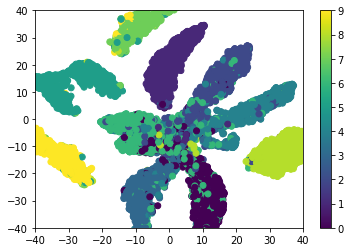

Epoch 19/20
----------
Epoch 19 Iteration 0: Loss = 6.718626022338867
Epoch 19 Iteration 100: Loss = 2.4901418685913086
Epoch 19 Iteration 200: Loss = 2.6808061599731445
Epoch 19 Iteration 300: Loss = 5.529946327209473
Epoch 19 Iteration 400: Loss = 5.455217361450195
Epoch 19 Iteration 500: Loss = 0.25694534182548523
Epoch 19 Iteration 600: Loss = 5.427652835845947
Epoch 19 Iteration 700: Loss = 4.42406702041626
Epoch 19 Iteration 800: Loss = 6.637334823608398
Epoch 19 Iteration 900: Loss = 3.4259390830993652


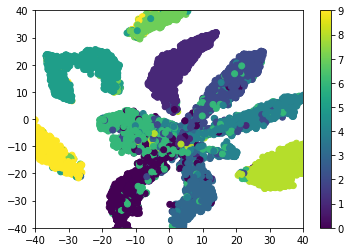

Epoch 20/20
----------
Epoch 20 Iteration 0: Loss = 5.461237907409668
Epoch 20 Iteration 100: Loss = 3.7407004833221436
Epoch 20 Iteration 200: Loss = 3.0568714141845703
Epoch 20 Iteration 300: Loss = 2.706665515899658
Epoch 20 Iteration 400: Loss = 4.344848155975342
Epoch 20 Iteration 500: Loss = 6.081469535827637
Epoch 20 Iteration 600: Loss = 3.6475493907928467
Epoch 20 Iteration 700: Loss = 1.741517424583435
Epoch 20 Iteration 800: Loss = 4.140542507171631
Epoch 20 Iteration 900: Loss = 2.3540217876434326


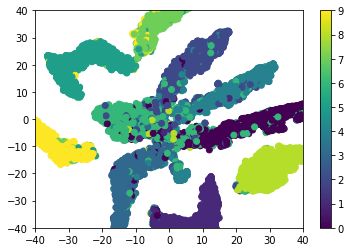

In [12]:
if __name__ == '__main__':
    
    model = CustomModel(model_name=CFG.model_name[2]).to(CFG.device)
    optimizer = optim.Adam(model.parameters(), lr=CFG.lr)
    
    test_predicted_metrics = []
    test_true_labels = []
    model_loss = 0
    best_model_loss = 100


    distance = CosineSimilarity()
    reducer = ThresholdReducer(low = 0)
    losser = TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
    miner = TripletMarginMiner(margin=0.2, distance=distance)
    
    loss_func = losser
    mining_func = miner
    loss_func = losses.SubCenterArcFaceLoss(num_classes=10, embedding_size=128).to(CFG.device)
    
    for epoch in range(1, CFG.epoch + 1):
        print('Epoch {}/{}'.format(epoch, CFG.epoch))
        print('-' * 10)
        train(model, loss_func, mining_func, CFG.device, train_loader, optimizer, epoch)
#         if epoch % 5 == 0 or epoch ==1:
        torch.save(model.state_dict(),OUTPUT_DIR + "/" + f'epoch{epoch}_model.pth')
        tsne(epoch)
    
    #create mp4 
    create_gif()

In [13]:
# tSNE_metrics = TSNE(n_components=2, random_state=0).fit_transform(test_predicted_metrics)

# plt.scatter(tSNE_metrics[:, 0], tSNE_metrics[:, 1], c=test_true_labels)
# plt.colorbar()
# plt.savefig("output.png")
# plt.show()